In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons, make_blobs

sns.set_style('whitegrid')

# Problem 1
Implement k-means algorithm by `numpy`.

In [2]:
class MyKMeans:
    def __init__(self, n_clusters=8, n_iter=300, tol=1e-5, n_init=10, init='k-means++'):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.tol = tol
        self.n_init = n_init
        self.centers = None
        self.labels = None
        self.init = init

    def kmeans_plus_plus(self, X):
        # Initialize centers using k-means++ algorithm
        centers = np.zeros((self.n_clusters, X.shape[1]))
        centers[0] = X[np.random.choice(len(X))]

        for i in range(1, self.n_clusters):
            dist = np.linalg.norm(X[:, None] - centers[:i], axis=2).min(axis=1)
            prob = dist / dist.sum()
            centers[i] = X[np.random.choice(len(X), p=prob)]

        for _ in range(self.n_iter):
            labels = np.argmin(np.linalg.norm(X[:, None] - centers, axis=2), axis=1)
            new_centers = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.linalg.norm(new_centers - centers) < self.tol:
                break
            centers = new_centers

        self.labels = labels
        return centers

    def kmeans_random(self, X):
        # Initialize centers 10 times and choose the best one
        best_score = np.inf

        for _ in range(self.n_init):
            centers = X[np.random.choice(len(X), self.n_clusters, replace=False)]
            for _ in range(self.n_iter):
                labels = np.argmin(np.linalg.norm(X[:, None] - centers, axis=2), axis=1)
                new_centers = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
                if np.linalg.norm(new_centers - centers) < self.tol:
                    break
                centers = new_centers

            score = np.linalg.norm(X[:, None] - centers, axis=2).min(axis=1).sum()
            
            if score < best_score:
                best_score = score
                self.centers = centers
                self.labels = labels

        return self.centers

    def fit(self, X):
        if self.init == 'k-means++':
            self.centers = self.kmeans_plus_plus(X)
        else:
            self.centers = self.kmeans_random(X)


    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, None] - self.centers, axis=2), axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels
    
    def score(self, X):
        # Calculate inertia
        inertia = 0
        for i in range(self.n_clusters):
            inertia += np.linalg.norm(X[self.labels == i] - self.centers[i])**2
        return inertia

In [3]:
def plot_comparison(kmeans, sk_kmeans, X):
    # Plot comparison subplot
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans.labels, ax=axes[0], palette='Set2')
    sns.scatterplot(x=kmeans.centers[:, 0], y=kmeans.centers[:, 1], color='red', ax=axes[0], s=100)
    axes[0].set_title('My KMeans')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=sk_kmeans.labels_, ax=axes[1], palette='Set2')
    sns.scatterplot(x=sk_kmeans.cluster_centers_[:, 0], y=sk_kmeans.cluster_centers_[:, 1], color='red', ax=axes[1], s=100)
    axes[1].set_title('sklearn KMeans')
    plt.show()

# Problem 2
Use "Wine dataset" and choose 2 features according to your preference. Run the k-means algorithm built in the first question. Try 3 different numbers of cluster and visualize the clustering result to see if there is any difference.

In [4]:
wine_df = pd.read_csv('../data/wine-clustering.csv')
wine_df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
selected_attr = ['Alcohol', 'Total_Phenols']
print(selected_attr)
X = wine_df[selected_attr].values
X.shape

['Alcohol', 'Total_Phenols']


(178, 2)

Silhouette score: My KMeans: 0.4420794555696148, sklearn KMeans: 0.4420794555696148


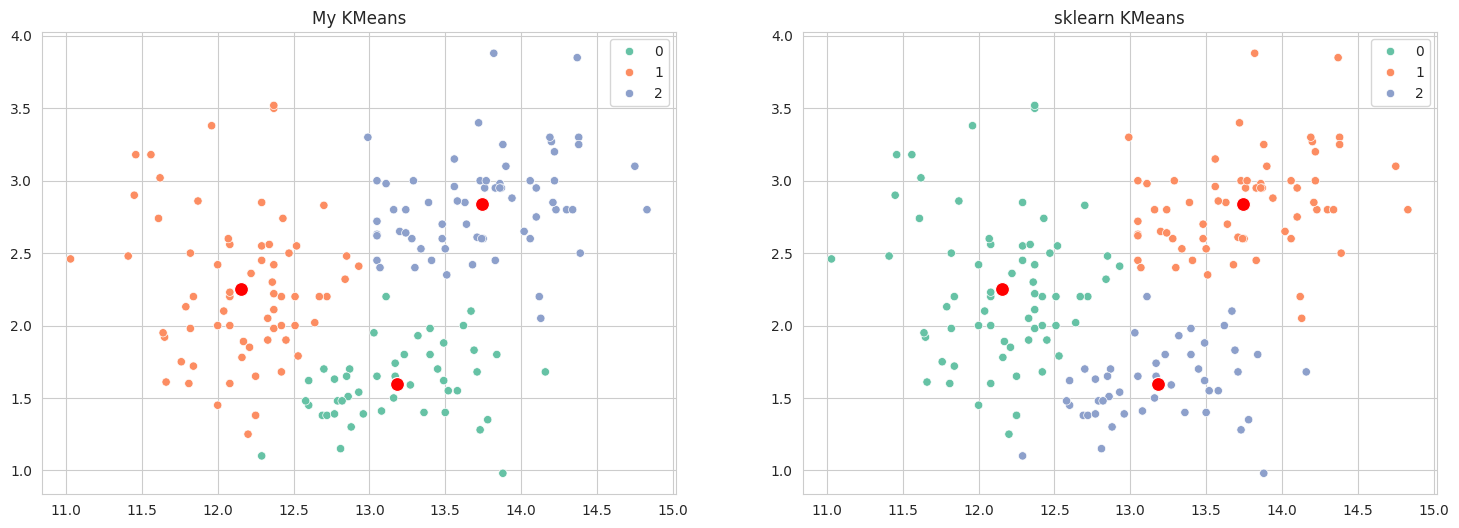

In [6]:
kmeans = MyKMeans(n_clusters=3, n_init=5)
kmeans.fit(X)

# Compare with sklearn
sk_kmeans = KMeans(n_clusters=3, n_init=5, init='random')
sk_kmeans.fit(X)

# Plot comparison
print(f'Silhouette score: My KMeans: {silhouette_score(X, kmeans.labels)}, sklearn KMeans: {silhouette_score(X, sk_kmeans.labels_)}')
plot_comparison(kmeans, sk_kmeans, X)

Silhouette score: My KMeans: 0.44799301232788286	 sklearn KMeans: 0.44799301232788286


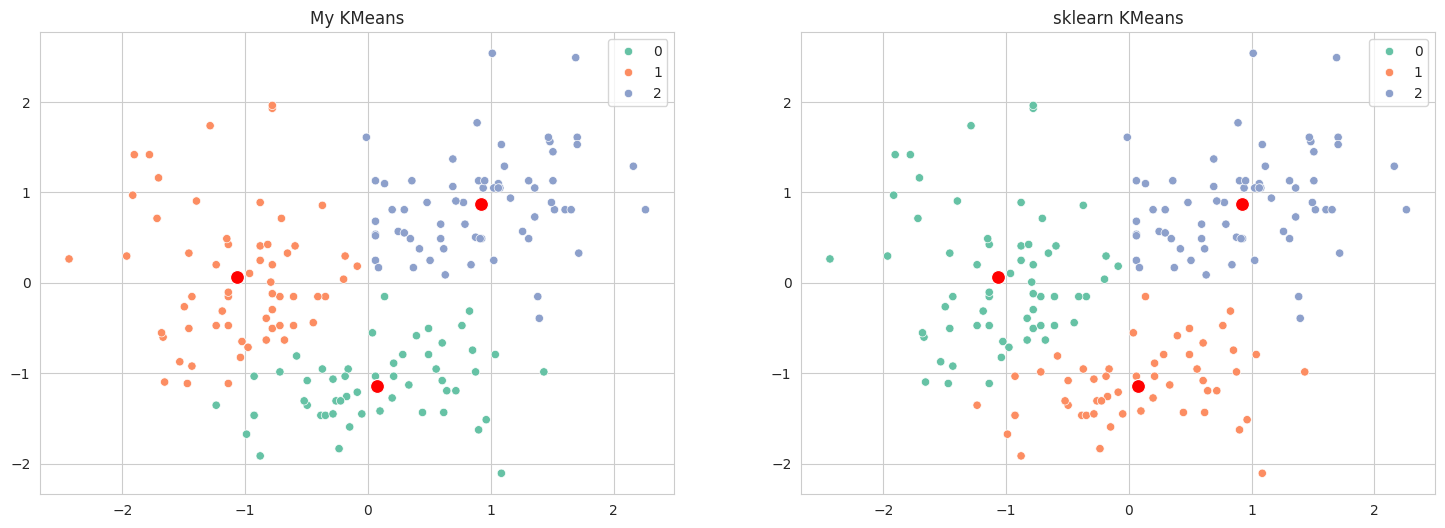

In [7]:
X_std = (X - X.mean(axis=0)) / X.std(axis=0)
kmeans = MyKMeans(n_clusters=3, n_init=5)
kmeans.fit(X_std)

# Plot comparison subplot
sk_kmeans = KMeans(n_clusters=3, n_init=5, init='random')
sk_kmeans.fit(X_std)

# Plot comparison subplot
print(f'Silhouette score: My KMeans: {silhouette_score(X_std, kmeans.labels)}\t sklearn KMeans: {silhouette_score(X_std, sk_kmeans.labels_)}') 
plot_comparison(kmeans, sk_kmeans, X_std)

Silhouette score: My KMeans: 0.4377889947239076	 sklearn KMeans: 0.4377889947239076


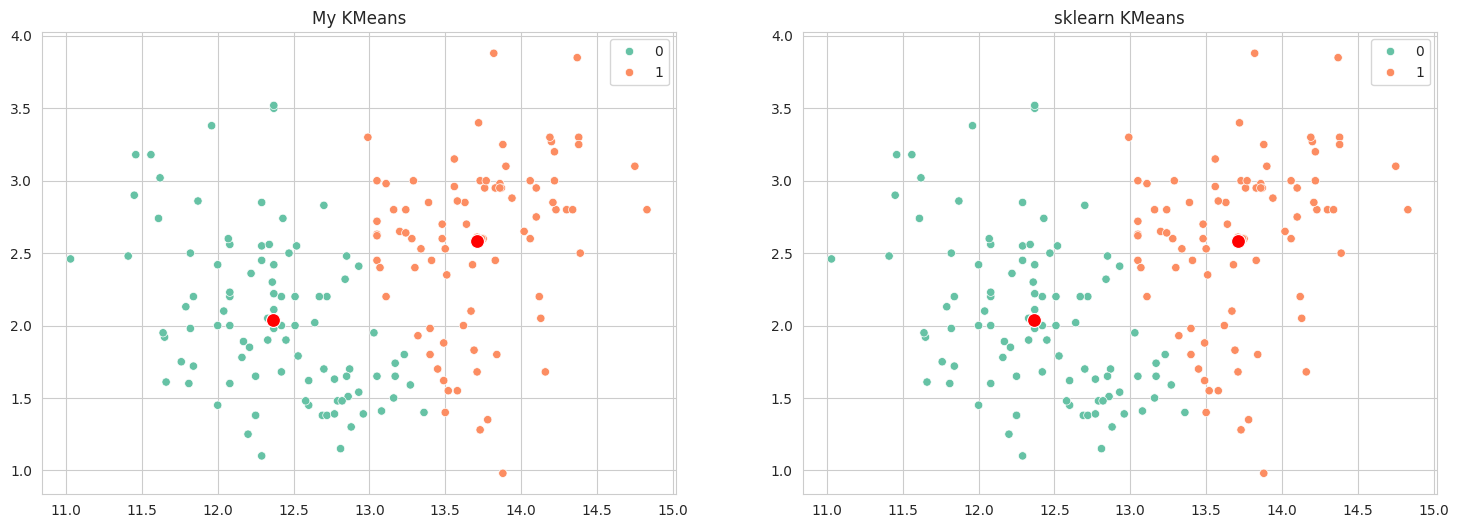

Silhouette score: My KMeans: 0.43919614923122996	 sklearn KMeans: 0.43919614923122996


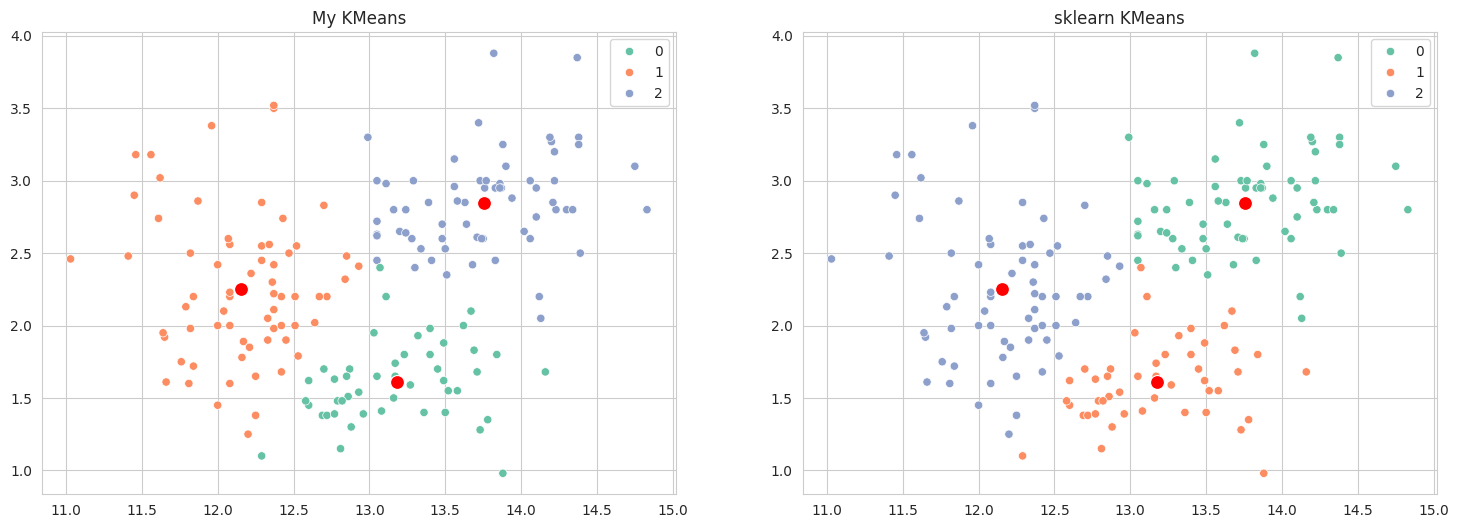

Silhouette score: My KMeans: 0.39512837928292394	 sklearn KMeans: 0.396985525564962


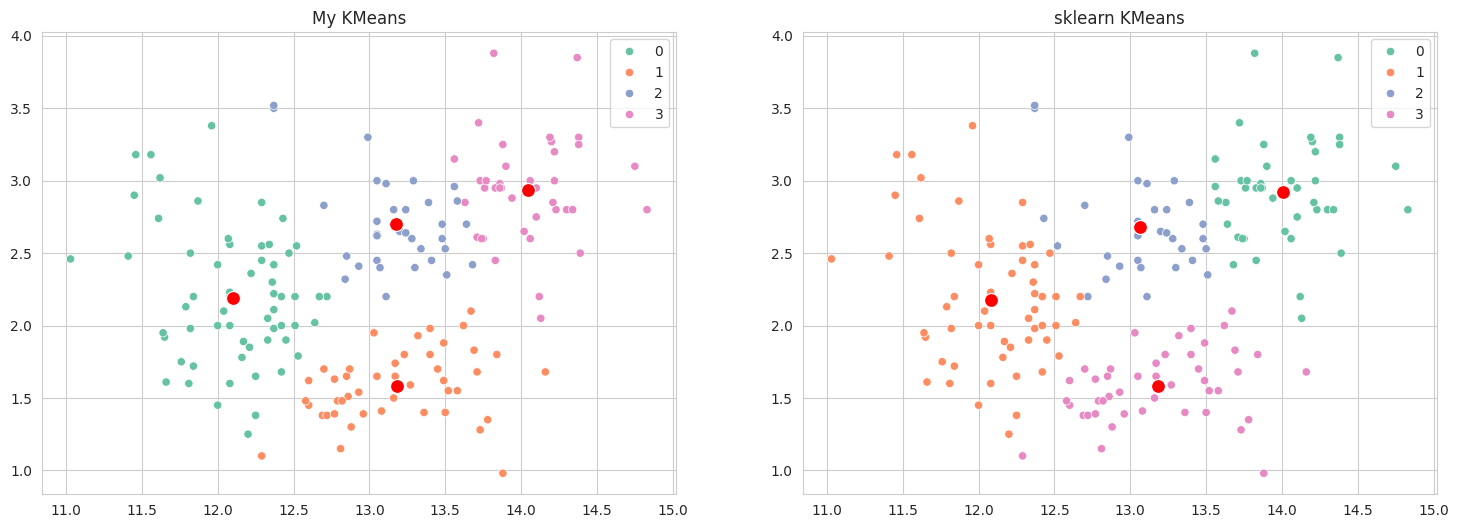

In [8]:
# Try 3 different numbers of cluster and visualize the clustering result to see if there is any difference.
for i in range(2, 5):
    kmeans = MyKMeans(n_clusters=i, n_init=10, init='random')
    kmeans.fit(X)
    sk_kmeans = KMeans(n_clusters=i, n_init=10, init='random')
    sk_kmeans.fit(X)
    print(f'Silhouette score: My KMeans: {silhouette_score(X, kmeans.labels)}\t sklearn KMeans: {silhouette_score(X, sk_kmeans.labels_)}')
    plot_comparison(kmeans, sk_kmeans, X)

# Problem 3
Read and understand how to choose the optimal number of cluster (https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/). Draw the elbow for the whole "Wine" dataset (all features).

In [9]:
X_all_features = wine_df.values
X_all_features.shape

(178, 13)

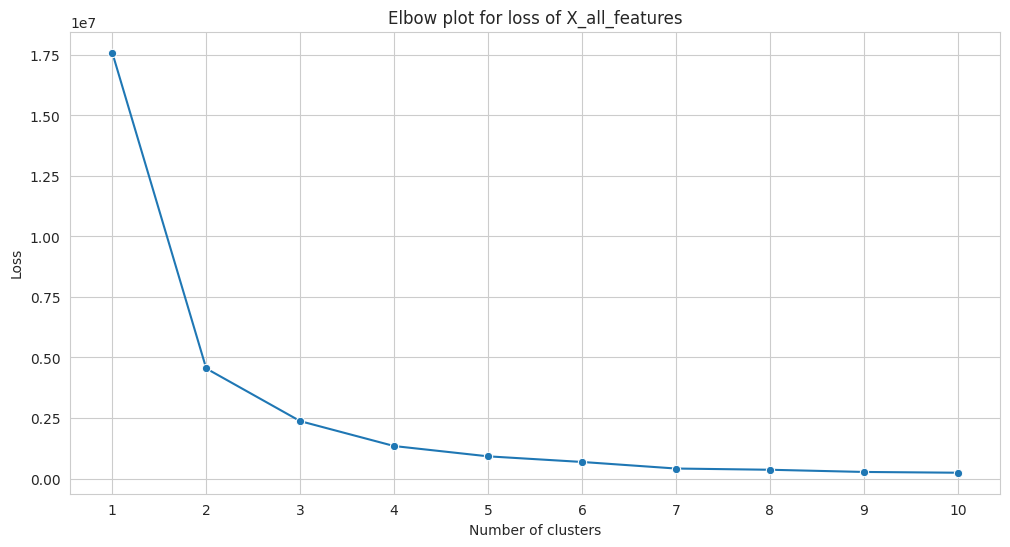

In [10]:
# Draw elbow plot for loss of X_all_features
loss = []
for i in range(1, 11):
    kmeans = MyKMeans(n_clusters=i, n_init=10, init='random')
    kmeans.fit(X_all_features)
    loss.append(kmeans.score(X_all_features))

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, 11), y=loss, markers=True, marker='o')
plt.xticks(range(1, 11))
plt.xlabel('Number of clusters')
plt.ylabel('Loss')
plt.title('Elbow plot for loss of X_all_features')
plt.show()

# Problem 4
Read the limitation of k-means (https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages), find at least three examples that k-means doesn't work.

### Disadvantages of k-means
1. Choosing $k$ manually.

Use the “Loss vs. Clusters” plot to find the optimal (k), as discussed in Interpret Results.

2. Being dependent on initial values.

For a low $k$, you can mitigate this dependence by running k-means several times with different initial values and picking the best result. As $k$ increases, you need advanced versions of k-means to pick better values of the initial centroids (called k-means seeding). For a full discussion of k- means seeding see, A Comparative Study of Efficient Initialization Methods for the K-Means Clustering Algorithm by M. Emre Celebi, Hassan A. Kingravi, Patricio A. Vela.

3. Clustering data of varying sizes and density.

k-means has trouble clustering data where clusters are of varying sizes and density. To cluster such data, you need to generalize k-means as described in the Advantages section.

4. Clustering outliers.

Centroids can be dragged by outliers, or outliers might get their own cluster instead of being ignored. Consider removing or clipping outliers before clustering.

5. Scaling with number of dimensions.

As the number of dimensions increases, a distance-based similarity measure converges to a constant value between any given examples. Reduce dimensionality either by using PCA on the feature data, or by using “spectral clustering” to modify the clustering algorithm as explained below.

### Cases where k-means doesn not work
- Non-globular structure
- Noise and outliers

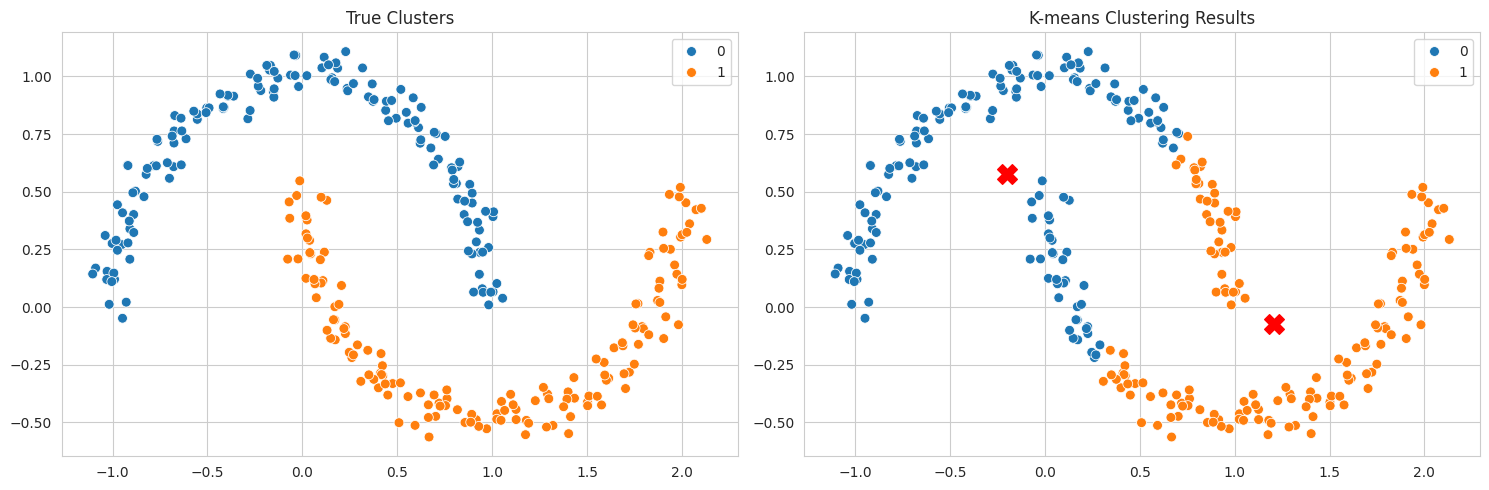

In [11]:
# Generate crescent-shaped clusters
X, true_labels = make_moons(n_samples=300, noise=0.05, random_state=42)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X)
labels = kmeans.labels_

# Plot the data and K-means clustering results
plt.figure(figsize=(15, 5))

# True clusters (ground truth)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=true_labels, s=50)
plt.title('True Clusters')

# K-means clustering results
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-means Clustering Results')

plt.tight_layout()
plt.show()

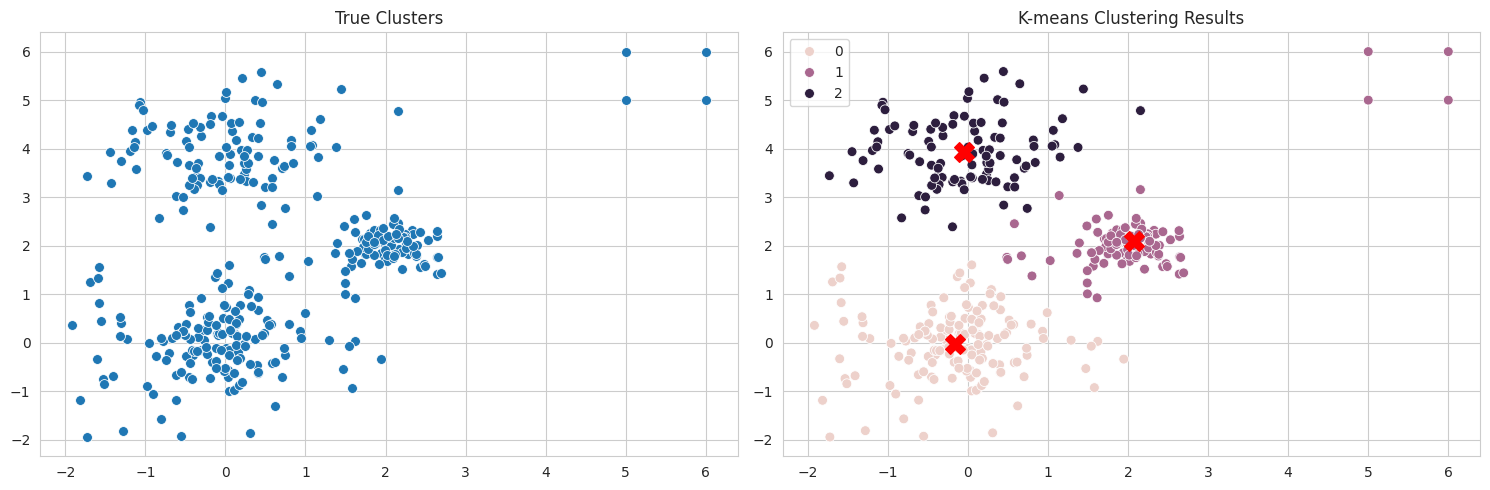

In [12]:
# Generate a dataset with clusters of different densities, noise, and outliers
X, _ = make_blobs(n_samples=300, centers=[[0, 0], [2, 2], [0, 4]], cluster_std=[0.5, 0.3, 0.7], random_state=42)

# Introduce noise points
noise_points = np.random.rand(50, 2) * np.array([4, 4]) - np.array([2, 2])
X = np.concatenate([X, noise_points])

# Introduce outliers
outliers = np.array([[5, 5], [5, 6], [6, 5], [6, 6]])
X = np.concatenate([X, outliers])

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)
labels = kmeans.labels_

# Plot the data and K-means clustering results
plt.figure(figsize=(15, 5))

# True clusters (ground truth)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=50)
plt.title('True Clusters')

# K-means clustering results
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-means Clustering Results')

plt.tight_layout()
plt.show()

# Problem 5 (Optional)
You learnt about what is k-means++. Explain how k-means++ works AND implement k-means++ algo as you wish.

K-means++ improves the classic k-means algorithm by **smartly choosing initial cluster centers**, leading to faster convergence and better quality clusters.

1. **Start with one random point:** Choose a data point as the first cluster center.
2. **Grow the seeds:** For each remaining center:
    - Calculate the distance of each data point to the existing centers.
    - **Probabilistically select a point** based on its distance (closer points have higher chance).
    - This point becomes the new center.
3. **Repeat steps 2 until k centers are chosen.**
4. **Run regular k-means:** Assign data points to the closest center, then refine centers until stable.

**Benefits:**

* **Avoids bad initializations:** Starts with diverse centers, preventing clusters stuck in local minima.
* **Faster convergence:** Reaches optimal clusters quicker due to better initial placement.
* **Improved cluster quality:** Leads to more representative and meaningful clusters.

Silhouette score: My KMeans: 0.6572176888364498	 sklearn KMeans: 0.6572176888364498


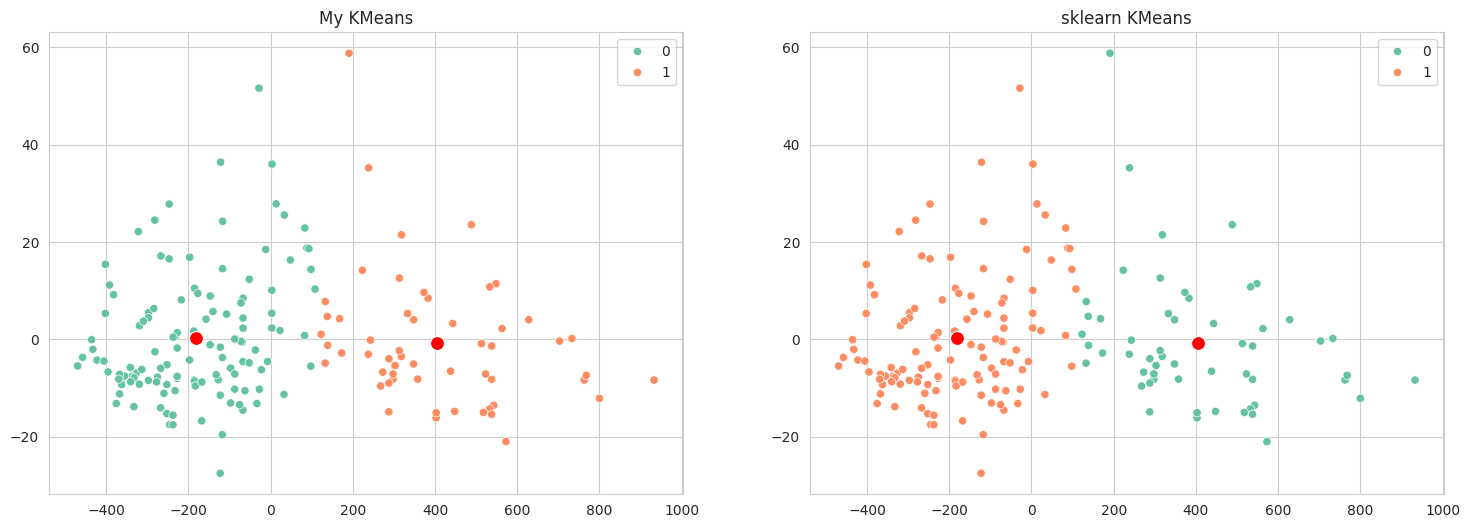

Silhouette score: My KMeans: 0.5722554756855064	 sklearn KMeans: 0.5722554756855064


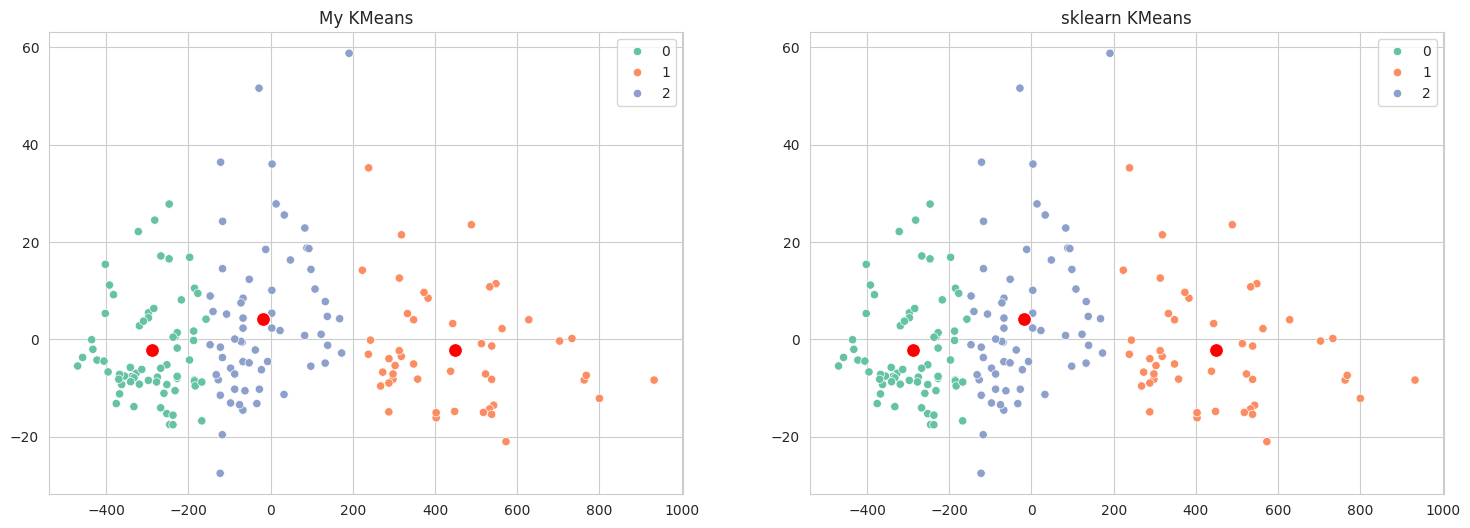

Silhouette score: My KMeans: 0.563440581821602	 sklearn KMeans: 0.5620832629069178


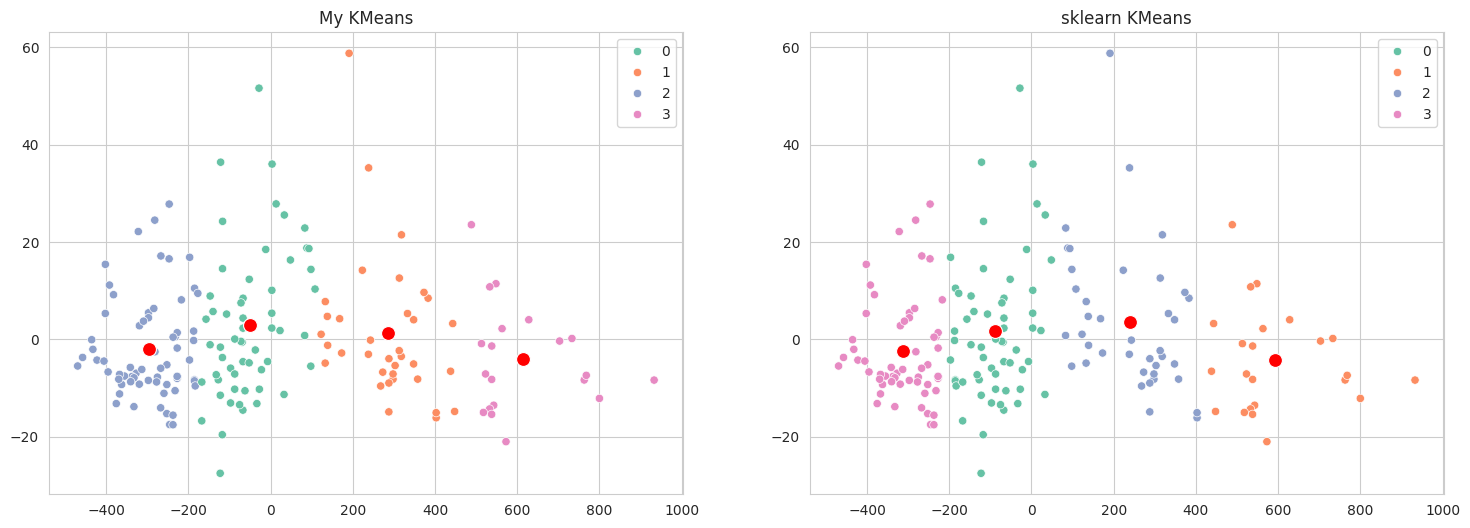

In [13]:
# Initialize X
X = wine_df.values

# Reduce the dimensionality of X
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# Try 3 different numbers of cluster and visualize the clustering result to see if there is any difference.
for i in range(2, 5):
    kmeans = MyKMeans(n_clusters=i, n_init=10, init='k-means++')
    kmeans.fit(X)
    sk_kmeans = KMeans(n_clusters=i, n_init=10, init='k-means++')
    sk_kmeans.fit(X)
    print(f'Silhouette score: My KMeans: {silhouette_score(X, kmeans.labels)}\t sklearn KMeans: {silhouette_score(X, sk_kmeans.labels_)}')
    plot_comparison(kmeans, sk_kmeans, X)